# Practical 7 - Part 1B
The aim of part 1B is to use the homography routine
that you established in the first part of the practical.  We are going to
make a panorama of several images that are related by a homography.  We
provide 3 images (one of which is has a large surrounding region) and a
matching set of points between these images.

# Import libraries 

In [1]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# Load and plot the images 

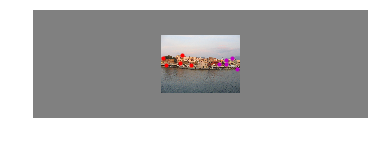

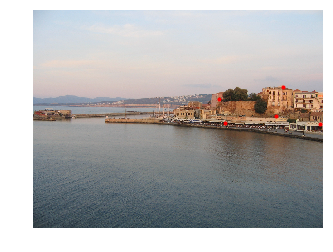

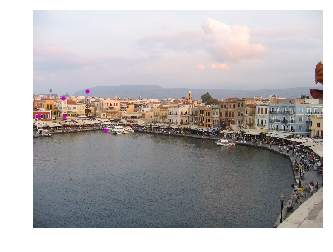

In [2]:
# Load data
data = sio.loadmat('PracticalData.mat', squeeze_me = True);
# Unpack data
# im1 is center image with grey background
im1 = data['im1']
# im2 is left image 
im2 = data['im2']
# pts1 and pts2 are matching points between image1 and image2
pts1 = data['pts1']
pts2 = data['pts2']
# im3 is right image
im3 = data['im3']
# pts1b and pts3 are matching points between image 1 and image 3
pts1b = data['pts1b']
pts3 = data['pts3']

# Show images and points 
plt.imshow(im1)
plt.plot(pts1[0,:],pts1[1,:],'r.')
plt.plot(pts1b[0,:],pts1b[1,:],'m.')
plt.axis('off')
plt.show()

plt.imshow(im2)
plt.plot(pts2[0,:],pts2[1,:],'r.')
plt.axis('off')
plt.show()

plt.imshow(im3)
plt.plot(pts3[0,:],pts3[1,:],'m.')
plt.axis('off')
plt.show()

## Comments
The red points represent matching points between image 1 and image 2. The purple points represent matching points between image 1 and image 3.  A panorama of images can be generated by aligning these matching points to calculate Homography matrix.

# **** TO DO **** Now use the functions you completed in part 1A (solveAXEqualsZero, calcBestHomography) to make a panoramic image. 

In [3]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0   
    #Compute SVD of matrix A
    u, s, vh = np.linalg.svd(A)
    #set h to the last column of V
    h = vh.T[:,-1]
    return h

In [4]:
# This function should apply the direct linear transform (DLT) algorithm to calculate the best 
# homography that maps the points in pts1Cart to their corresonding matching in pts2Cart
def calcBestHomography(pts1Cart, pts2Cart):    
    # TO DO: replace this
    H = np.zeros([3,3])

    # TO DO: 
    # First convert points into homogeneous representation
    pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    # Then construct the matrix A, size (n_points,9)  
    #map from 2D -> 2D
    n_points = pts1Cart.shape[1]
    A = np.zeros([2*n_points,9])

    #find the matrix relates to X
    #pts2Cart - dxn
    # value of x in the second coordinate system
    coord2_X = np.tile(pts2Cart[0,:],(3,1)).T
    # value of y in the second coordinate system
    coord2_Y = np.tile(pts2Cart[1,:],(3,1)).T
    
    #concentrate the matrix
    X = np.hstack((pts1Hom.T,np.zeros([n_points,3]),(coord2_X*(-pts1Hom.T))))
    Y = np.hstack((np.zeros([n_points,3]),-pts1Hom.T,(coord2_Y*(pts1Hom.T))))
    
    for i in range(n_points):
        indexRelates_y = 2*i
        indexRelates_x = 2*i + 1
        A[indexRelates_x] = X[i]
        A[indexRelates_y] = Y[i]

    # Solve Ah = 0
    h = solveAXEqualsZero(A)
    # Reshape h into the matrix H, values of h go first into rows of H
    H = np.reshape(h,H.shape)
    return H

In [5]:
# TO DO: Calculate homography from pts1 to pts2 
HEst1_2 = calcBestHomography(pts1, pts2)

# TO DO: 
# For every pixel in image 1:
    # Transform this pixel position with your homography to find where it is in the coordinates of image 2
    # If it the transformed position is within the boundary of image 2: 
    #     Copy pixel colour from image 2 pixel to current position in image 1 
    #     Draw new image1

# find the coordinate of all points in image1
X, Y = np.mgrid[0:im1.shape[1], 0:im1.shape[0]]
point1 = np.vstack((X.ravel(), Y.ravel()))
# convert points into homogeneous representation
pts1Hom = np.concatenate((point1, np.ones((1,point1.shape[1]))), axis=0)

# Apply estimated homography to points
pts2EstHom = np.matmul(HEst1_2,pts1Hom)
# Convert back to Cartesian coordinates
pts2EstCart = pts2EstHom[0:2,:] / np.tile([pts2EstHom[2,:]],(2,1))
    
# For each transformed point, check whether the point is outside the current boundary
for i in range(pts2EstCart.shape[1]):
    # x >= 0 && x <= cols   y >= 0 && y <= rows
    if pts2EstCart[0,i] >= 0 and pts2EstCart[0,i] <= im2.shape[1] and pts2EstCart[1,i] >=0 \
    and  pts2EstCart[1,i] <= im2.shape[0]:
        im1[int(point1[1,i]),int(point1[0,i]),:] = im2[int(pts2EstCart[1,i]),int(pts2EstCart[0,i]),:]

            
            
    
# TO DO: Repeat the above process mapping image 3 to image 1.
HEst1_3 = calcBestHomography(pts1b, pts3)

# TO DO: 
# For every pixel in image 1:
    # Transform this pixel position with your homography to find where it is in the coordinates of image 2
    # If it the transformed position is within the boundary of image 2: 
    #     Copy pixel colour from image 2 pixel to current position in image 1 
    #     Draw new image1


# Apply estimated homography to points
pts3EstHom = np.matmul(HEst1_3,pts1Hom)
# Convert back to Cartesian coordinates
pts3EstCart = pts3EstHom[0:2,:] / np.tile([pts3EstHom[2,:]],(2,1))
    
# For each transformed point, check whether the point is outside the current boundary
for i in range(pts3EstCart.shape[1]):
    # x >= 0 && x <= cols   y >= 0 && y <= rows
    if pts3EstCart[0,i] >= 0 and pts3EstCart[0,i] <= im3.shape[1] and pts3EstCart[1,i] >=0 \
    and  pts3EstCart[1,i] <= im3.shape[0]:
        im1[int(point1[1,i]),int(point1[0,i]),:] = im3[int(pts3EstCart[1,i]),int(pts3EstCart[0,i]),:]

## Comments
First, determined pairs of matching points are used to find the homography matrix between image 1 and image 2 and also the homography matrix between image 1 and image 3. 
After calculating the homography matrix, points in the first image are mapped to the second image and the third image.  The homography matrix is applied to the points in the first image to find estimated points in the second or the third image. Then, for all the mapped points from the first image is required to be checked that the point is inside the boundary of current image. If the point is inside the boundary, the infomation of the pixel is copied from image 2 and image 3 to the current position in image 1.


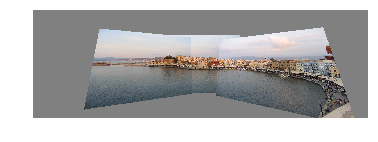

In [6]:
# Plot the final panorama
plt.imshow(im1)
plt.axis('off')
plt.show()